In [1]:
# cell 01
from google.colab import drive
import os

In [2]:
# cell 02
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully!")

Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive mounted successfully!


In [3]:
# cell 03
DATA_PATH = "/content/drive/MyDrive/FYP Model training/data"

In [ ]:
# cell 04
%pip install librosa resampy scikit-learn imbalanced-learn seaborn matplotlib pandas numpy joblib scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.4 MB/s eta 0:00:00


In [6]:
# cell 05
import os
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import joblib
import warnings
from collections import Counter
import random
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [11]:
# cell 06
class ImprovedBabyCryDetectionTrainer:
    def __init__(self, data_path):
        self.data_path = data_path
        self.model = None
        self.scaler = None
        self.label_encoder = None
        self.feature_columns = None

    def traverse_subfolders(self, subfolders):
        """Traverse subfolders and get audio files with their labels"""
        audio_files = []
        subfolder_names = []

        for subfolder in subfolders:
            if not os.path.exists(subfolder):
                print(f"Warning: Subfolder {subfolder} does not exist. Skipping...")
                continue

            subfolder_name = os.path.basename(subfolder)
            files = self.get_audio_files(subfolder)
            print(f"Found {len(files)} files in {subfolder_name}")
            audio_files.extend(files)
            subfolder_names.extend([subfolder_name] * len(files))

        return audio_files, subfolder_names

    def get_audio_files(self, subfolder):
        """Get all .wav files from a subfolder"""
        audio_files = []
        for root, dirs, files in os.walk(subfolder):
            for file in files:
                if file.lower().endswith((".wav", ".mp3", ".m4a", ".flac")):
                    audio_files.append(os.path.join(root, file))
        return audio_files

    def enhanced_features_extractor(self, file_name):
        """Extract enhanced features from audio file"""
        try:
            # Load audio with different parameters for robustness
            audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast',
                                            duration=None, sr=22050)

            # If audio is too short, pad it
            if len(audio) < sample_rate:
                audio = np.pad(audio, (0, sample_rate - len(audio)), mode='constant')

            # If audio is too long, take multiple segments
            if len(audio) > sample_rate * 5:  # If longer than 5 seconds
                # Take first 3 seconds
                audio = audio[:sample_rate * 3]

            features = []

            # 1. MFCC features (most important for speech/cry recognition)
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
            mfccs_mean = np.mean(mfccs, axis=1)
            mfccs_std = np.std(mfccs, axis=1)
            features.extend(mfccs_mean)
            features.extend(mfccs_std)

            # 2. Spectral features
            spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
            features.append(np.mean(spectral_centroids))
            features.append(np.std(spectral_centroids))

            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)[0]
            features.append(np.mean(spectral_rolloff))
            features.append(np.std(spectral_rolloff))

            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)[0]
            features.append(np.mean(spectral_bandwidth))
            features.append(np.std(spectral_bandwidth))

            # 3. Zero crossing rate
            zcr = librosa.feature.zero_crossing_rate(audio)[0]
            features.append(np.mean(zcr))
            features.append(np.std(zcr))

            # 4. Root Mean Square Energy
            rms = librosa.feature.rms(y=audio)[0]
            features.append(np.mean(rms))
            features.append(np.std(rms))

            # 5. Chroma features
            chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
            features.extend(np.mean(chroma, axis=1))

            # 6. Mel-scale spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
            mel_features = np.mean(mel_spectrogram, axis=1)
            features.extend(mel_features[:10])  # Take first 10 mel features

            return np.array(features)

        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            return None

    def process_audio_files(self, audio_files, subfolder_names):
        """Process all audio files and extract features"""
        data = []
        failed_files = []

        print(f"Processing {len(audio_files)} audio files...")

        for i, (audio_file, subfolder_name) in enumerate(zip(audio_files, subfolder_names)):
            if i % 50 == 0:
                print(f"Processed {i}/{len(audio_files)} files")

            features = self.enhanced_features_extractor(audio_file)
            if features is not None:
                data.append([audio_file, features, subfolder_name])
            else:
                failed_files.append(audio_file)

        if failed_files:
            print(f"Failed to process {len(failed_files)} files")

        df = pd.DataFrame(data, columns=["File", "Features", "Class"])
        return df

    def prepare_dataset(self, test_split=0.2):
        """Prepare the complete dataset with proper train/test split"""
        # Define your subfolder paths here - UPDATE THESE PATHS
        subfolders = [
            os.path.join(self.data_path, 'belly_pain'),
            os.path.join(self.data_path, 'burping'),
            os.path.join(self.data_path, 'discomfort'),
            os.path.join(self.data_path, 'hungry'),
            os.path.join(self.data_path, 'tired')
        ]

        # Get audio files and labels
        audio_files, subfolder_names = self.traverse_subfolders(subfolders)
        print(f"Found {len(audio_files)} total audio files")

        if len(audio_files) == 0:
            raise ValueError("No audio files found. Please check your data path and folder structure.")

        # Process audio files
        df = self.process_audio_files(audio_files, subfolder_names)

        if len(df) == 0:
            raise ValueError("No features were extracted. Please check your audio files.")

        return df

    def analyze_dataset(self, df):
        """Analyze dataset distribution and quality"""
        print("Dataset Analysis:")
        print(f"Total samples: {len(df)}")
        print(f"Number of classes: {df['Class'].nunique()}")
        print("\nClass distribution:")
        class_counts = df['Class'].value_counts()
        print(class_counts)

        # Check for class imbalance
        max_count = class_counts.max()
        min_count = class_counts.min()
        imbalance_ratio = max_count / min_count
        print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")

        if imbalance_ratio > 5:
            print("⚠️  Severe class imbalance detected! This may cause bias towards majority class.")

        return class_counts

    def visualize_data(self, df):
        """Enhanced data visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Class distribution
        sns.countplot(data=df, x="Class", ax=axes[0,0])
        axes[0,0].set_title("Distribution of Baby Cry Classes")
        axes[0,0].tick_params(axis='x', rotation=45)

        # Class distribution (pie chart)
        class_counts = df['Class'].value_counts()
        axes[0,1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title("Class Distribution (Percentage)")

        # Feature statistics
        features_df = pd.DataFrame(df['Features'].tolist())
        feature_means = features_df.mean(axis=1)
        axes[1,0].hist(feature_means, bins=30, alpha=0.7)
        axes[1,0].set_title("Distribution of Feature Means")
        axes[1,0].set_xlabel("Mean Feature Value")

        # Feature correlation heatmap (sample)
        sample_features = features_df.iloc[:, :10]  # First 10 features
        correlation_matrix = sample_features.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
        axes[1,1].set_title("Feature Correlation (First 10 features)")

        plt.tight_layout()
        plt.show()

    def prepare_features(self, df):
        """Convert features to proper format for training"""
        # Convert features to DataFrame
        features_df = pd.DataFrame(df['Features'].tolist())

        # Get labels
        y = df['Class']

        # Store feature column names
        self.feature_columns = [f'feature_{i}' for i in range(features_df.shape[1])]
        features_df.columns = self.feature_columns

        return features_df, y

    def balance_dataset(self, X, y, method='smote'):
        """Balance the dataset using different techniques"""
        print(f"Original dataset shape: {X.shape}")
        print("Original class distribution:")
        print(Counter(y))

        if method == 'smote':
            # SMOTE is better for small datasets
            sampler = SMOTE(random_state=42, k_neighbors=min(5, min(Counter(y).values())-1))
        elif method == 'random_oversample':
            sampler = RandomOverSampler(random_state=42)
        elif method == 'smote_tomek':
            sampler = SMOTETomek(random_state=42)
        else:
            # Undersampling for extremely imbalanced datasets
            sampler = RandomUnderSampler(random_state=42)

        try:
            X_resampled, y_resampled = sampler.fit_resample(X, y)
            print(f"Resampled dataset shape: {X_resampled.shape}")
            print("Resampled class distribution:")
            print(Counter(y_resampled))
            return X_resampled, y_resampled
        except Exception as e:
            print(f"Error in balancing dataset: {e}")
            print("Proceeding with original imbalanced dataset...")
            return X, y

    def train_multiple_models(self, X_train, y_train, X_val, y_val):
        """Train and compare multiple models"""
        models = {
            'RandomForest': RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                class_weight='balanced'  # Important for imbalanced data
            ),
            'GradientBoosting': GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=42
            ),
            'SVM': SVC(
                kernel='rbf',
                C=10,
                gamma='scale',
                random_state=42,
                class_weight='balanced',
                probability=True
            )
        }

        results = {}
        trained_models = {}

        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train, y_train)

            # Validate
            y_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='weighted')

            results[name] = {'accuracy': accuracy, 'f1_score': f1}
            trained_models[name] = model

            print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

        # Select best model
        best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
        self.model = trained_models[best_model_name]

        print(f"\nBest model selected: {best_model_name}")
        print(f"Best F1-Score: {results[best_model_name]['f1_score']:.4f}")

        return results, trained_models

    def cross_validate_model(self, X, y, cv_folds=5):
      """Perform cross-validation"""
      if self.model is None:
          print("No model trained yet. Please train a model first.")
          return

      print(f"\nPerforming {cv_folds}-fold cross-validation...")

      # Use StratifiedKFold for more control over the cross-validation
      skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

      cv_scores = cross_val_score(self.model, X, y, cv=skf,
                                scoring='f1_weighted')

      print(f"Cross-validation F1-scores: {cv_scores}")
      print(f"Mean CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

      return cv_scores

    def evaluate_model(self, X_test, y_test, plot_cm=True):
        """Comprehensive model evaluation"""
        if self.model is None:
            print("No model trained yet.")
            return

        y_pred = self.model.predict(X_test)
        y_prob = self.model.predict_proba(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test F1-Score: {f1:.4f}")

        print("\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        if plot_cm:
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(y_test, y_pred)

            # Normalize confusion matrix
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                       xticklabels=self.label_encoder.classes_,
                       yticklabels=self.label_encoder.classes_)
            plt.title('Normalized Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.show()

        # Feature importance (for tree-based models)
        if hasattr(self.model, 'feature_importances_'):
            self.plot_feature_importance()

        return {'accuracy': accuracy, 'f1_score': f1, 'predictions': y_pred, 'probabilities': y_prob}

    def plot_feature_importance(self, top_n=20):
        """Plot feature importance"""
        if not hasattr(self.model, 'feature_importances_'):
            print("Model doesn't have feature importance.")
            return

        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(10, 6))
        plt.title(f"Top {top_n} Feature Importances")
        plt.bar(range(top_n), importances[indices])
        plt.xticks(range(top_n), [f'Feature {i}' for i in indices], rotation=45)
        plt.tight_layout()
        plt.show()

    def save_model(self, model_path="baby_cry_model.pkl",
                   encoder_path="label_encoder.pkl",
                   scaler_path="scaler.pkl"):
        """Save the trained model and preprocessing objects"""
        if self.model is None:
            print("No model to save.")
            return

        joblib.dump(self.model, model_path)
        joblib.dump(self.label_encoder, encoder_path)
        joblib.dump(self.feature_columns, "feature_columns.pkl")

        if self.scaler is not None:
            joblib.dump(self.scaler, scaler_path)

        print(f"Model saved to {model_path}")
        print(f"Label encoder saved to {encoder_path}")
        if self.scaler is not None:
            print(f"Scaler saved to {scaler_path}")

    def predict_single_audio(self, audio_file_path):
        """Predict the class of a single audio file"""
        if self.model is None:
            print("No model loaded. Please train or load a model first.")
            return None, None

        features = self.enhanced_features_extractor(audio_file_path)
        if features is not None:
            features_df = pd.DataFrame([features], columns=self.feature_columns)

            if self.scaler is not None:
                features_df = self.scaler.transform(features_df)

            prediction = self.model.predict(features_df)[0]
            probability = self.model.predict_proba(features_df)[0]

            # Get the class name
            predicted_class = self.label_encoder.inverse_transform([prediction])[0]
            confidence = np.max(probability)

            # Get all class probabilities
            all_probs = {}
            for i, class_name in enumerate(self.label_encoder.classes_):
                all_probs[class_name] = probability[i]

            return predicted_class, confidence, all_probs
        return None, None, None

    def run_improved_training_pipeline(self, balance_method='smote', use_scaling=True):
        """Run the complete improved training pipeline"""
        print("Starting Improved Baby Cry Detection Model Training...")

        # Prepare dataset
        df = self.prepare_dataset()
        print(f"Dataset prepared with {len(df)} samples")

        # Analyze dataset
        class_counts = self.analyze_dataset(df)

        # Visualize data distribution
        self.visualize_data(df)

        # Prepare features
        X, y = self.prepare_features(df)

        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)

        # Scale features if requested
        if use_scaling:
            self.scaler = StandardScaler()
            X = self.scaler.fit_transform(X)
            X = pd.DataFrame(X, columns=self.feature_columns)

        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        # Second split: training and validation from remaining data
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
        )

        print(f"Training set size: {X_train.shape[0]}")
        print(f"Validation set size: {X_val.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}")

        # Balance training data only
        X_train_balanced, y_train_balanced = self.balance_dataset(X_train, y_train, balance_method)

        # Train multiple models and select best
        results, trained_models = self.train_multiple_models(
            X_train_balanced, y_train_balanced, X_val, y_val
        )

        # Cross-validation
        cv_scores = self.cross_validate_model(X_train_balanced, y_train_balanced)

        # Final evaluation on test set
        print("\n" + "="*50)
        print("FINAL EVALUATION ON TEST SET")
        print("="*50)
        evaluation_results = self.evaluate_model(X_test, y_test)

        # Save model
        self.save_model()

        print("\nTraining pipeline completed successfully!")
        print("\nModel Performance Summary:")
        print(f"Final Test Accuracy: {evaluation_results['accuracy']:.4f}")
        print(f"Final Test F1-Score: {evaluation_results['f1_score']:.4f}")

        return evaluation_results


In [13]:
# Quick fix: Replace the problematic method
def fixed_cross_validate_model(self, X, y, cv_folds=5):
    """Perform cross-validation with error handling"""
    if self.model is None:
        print("No model trained yet. Please train a model first.")
        return

    print(f"\nPerforming {cv_folds}-fold cross-validation...")

    try:
        # Simple cross-validation without random_state
        cv_scores = cross_val_score(self.model, X, y, cv=cv_folds,
                                  scoring='f1_weighted')

        print(f"Cross-validation F1-scores: {cv_scores}")
        print(f"Mean CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        return cv_scores
    except Exception as e:
        print(f"Cross-validation failed: {e}")
        print("Skipping cross-validation and proceeding with training...")
        return None

# Apply the fix to your trainer
trainer.__class__.cross_validate_model = fixed_cross_validate_model

In [14]:
# cell 07
trainer = ImprovedBabyCryDetectionTrainer(DATA_PATH)

Starting Improved Baby Cry Detection Model Training...
Found 16 files in belly_pain
Found 8 files in burping
Found 27 files in discomfort
Found 382 files in hungry
Found 24 files in tired
Found 457 total audio files
Processing 457 audio files...
Processed 0/457 files
Processed 50/457 files
Processed 100/457 files
Processed 150/457 files
Processed 200/457 files
Processed 250/457 files
Processed 300/457 files
Processed 350/457 files
Processed 400/457 files
Processed 450/457 files
Dataset prepared with 457 samples
Dataset Analysis:
Total samples: 457
Number of classes: 5

Class distribution:
Class
hungry        382
discomfort     27
tired          24
belly_pain     16
burping         8
Name: count, dtype: int64

Class imbalance ratio: 47.75
⚠️  Severe class imbalance detected! This may cause bias towards majority class.


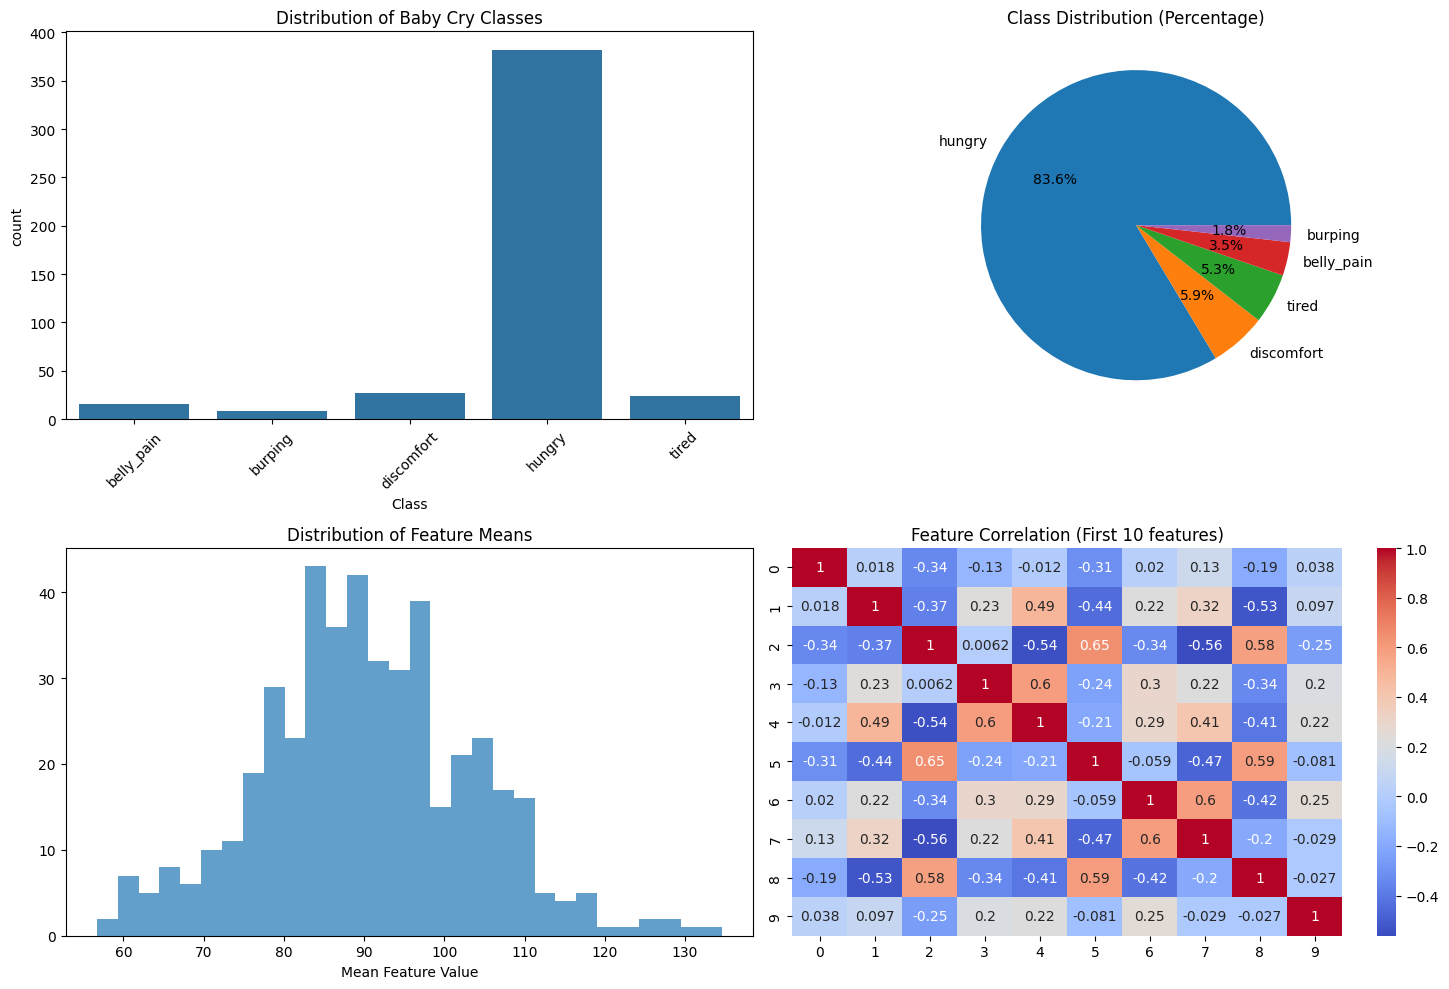

Training set size: 292
Validation set size: 73
Test set size: 92
Original dataset shape: (292, 58)
Original class distribution:
Counter({np.int64(3): 244, np.int64(2): 18, np.int64(4): 15, np.int64(0): 10, np.int64(1): 5})
Resampled dataset shape: (1220, 58)
Resampled class distribution:
Counter({np.int64(3): 244, np.int64(4): 244, np.int64(1): 244, np.int64(2): 244, np.int64(0): 244})

Training RandomForest...
RandomForest - Accuracy: 0.7945, F1-Score: 0.7657

Training GradientBoosting...
GradientBoosting - Accuracy: 0.7945, F1-Score: 0.7623

Training SVM...
SVM - Accuracy: 0.7808, F1-Score: 0.7565

Best model selected: RandomForest
Best F1-Score: 0.7657

Performing 5-fold cross-validation...
Cross-validation F1-scores: [1.         0.97512648 0.97497125 0.98346475 0.98760928]
Mean CV F1-score: 0.9842 (+/- 0.0185)

FINAL EVALUATION ON TEST SET
Test Accuracy: 0.7935
Test F1-Score: 0.7530

Detailed Classification Report:
              precision    recall  f1-score   support

           0

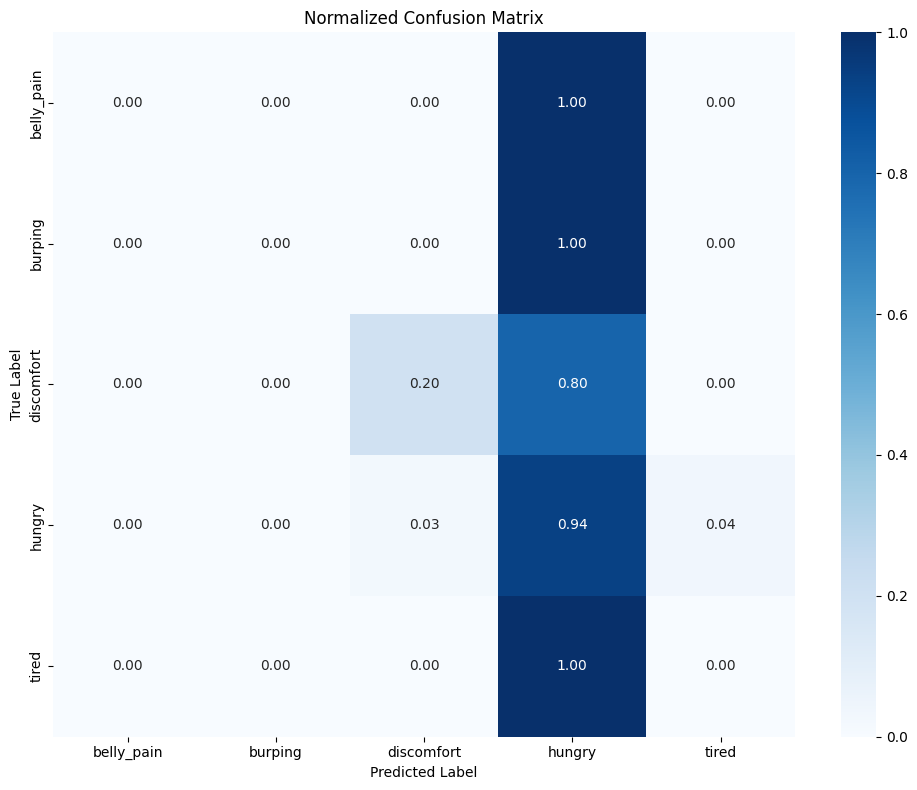

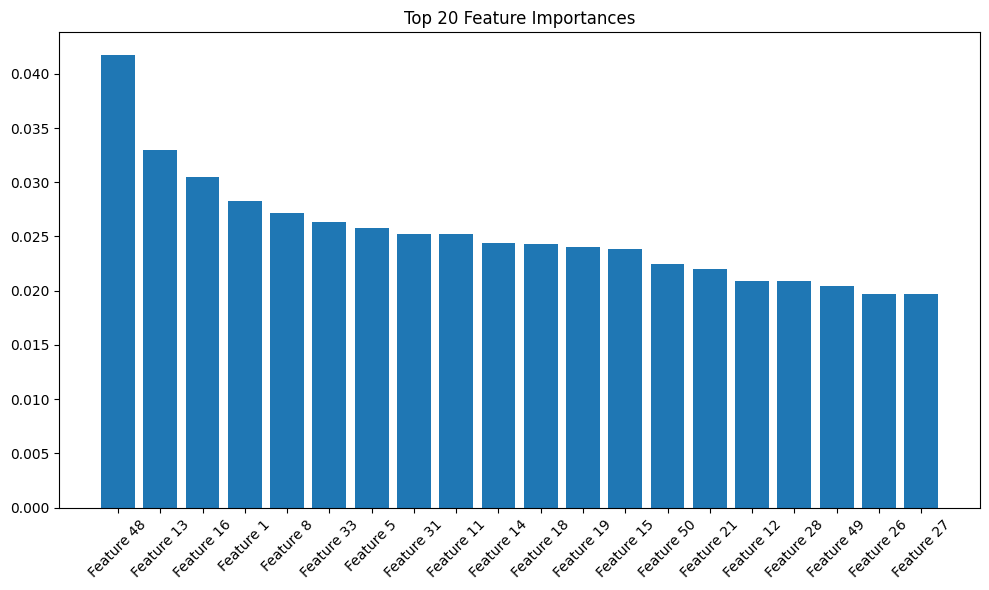

Model saved to baby_cry_model.pkl
Label encoder saved to label_encoder.pkl
Scaler saved to scaler.pkl

Training pipeline completed successfully!

Model Performance Summary:
Final Test Accuracy: 0.7935
Final Test F1-Score: 0.7530

🎉 Training completed successfully!


In [15]:
# cell 08
# Run improved training pipeline
try:
    results = trainer.run_improved_training_pipeline(
        balance_method='smote',  # Options: 'smote', 'random_oversample', 'smote_tomek', 'undersample'
        use_scaling=True
    )

    print("\n🎉 Training completed successfully!")

except Exception as e:
    print(f"❌ Error during training: {e}")
    print("\nPlease check:")
    print("1. Data path is correct")
    print("2. Audio files exist in the specified folders")
    print("3. Audio files are in supported formats (.wav, .mp3, .m4a, .flac)")